In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on sep 1 2020

SHAP analysis for a fully trained RF model.

@author: qiaohao liang
"""

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sklearn.ensemble
import operator
import warnings
from sklearn.exceptions import DataConversionWarning
import pickle
import sys
import shap
from set_figure_defaults import FigureDefaults


def fetch_pickle(filename):
    """
    Fetches any variable saved into a picklefile with the given filename.
    
    Parameters:
        filename (str): filename of the pickle file
        
    Returns:
        variable (any pickle compatible type): variable that was saved into the picklefile.
    """
    with open(filename, 'rb') as picklefile:
        variable = pickle.load(picklefile)
    return variable

def fetch_csv(filename, index_col=0):
    """
    Fetches any variable saved into a picklefile with the given filename.
    
    Parameters:
        filename (str): filename of the pickle file
        
    Returns:
        variable (any pickle compatible type): variable that was saved into the picklefile.
    """
    variable = pd.read_csv(filename+'.csv', index_col=index_col)
    return variable


In [2]:
print(sys.path)

['/home/armi/Dropbox (MIT)/Armiwork2019/2020/Bazan team/Codes/MLforCOE', '/home/armi/anaconda3/envs/coe-dmpnn-tl-selfies/lib/python38.zip', '/home/armi/anaconda3/envs/coe-dmpnn-tl-selfies/lib/python3.8', '/home/armi/anaconda3/envs/coe-dmpnn-tl-selfies/lib/python3.8/lib-dynload', '', '/home/armi/anaconda3/envs/coe-dmpnn-tl-selfies/lib/python3.8/site-packages', '/home/armi/anaconda3/envs/coe-dmpnn-tl-selfies/lib/python3.8/site-packages/IPython/extensions', '/home/armi/.ipython']


In [3]:
shap.initjs()

In [4]:
# This is the RF regressor trained with the full train dataset.
RF_Regressor = fetch_pickle('./Results/RF_regressor_opt_seed3')

# Opt. descriptors.
descriptors = ['MSD', 'MaxDD', 'TI2_L', 'MATS4v', 'MATS4i', 'P_VSA_MR_5', 'P_VSA_MR_6',
       'TDB06s', 'RDF040m', 'Mor20m', 'Mor25m', 'Mor31m', 'Mor10v', 'Mor20v',
       'Mor25v', 'Mor26s', 'R7u', 'H-046', 'H-047', 'SHED_AL', 'ALOGP']

# Molecules.
dataset = fetch_csv('./Data/dataset_outliers_dropped')

X_train = fetch_csv('./Data/Downselection_data_files/x_opt_train_seed3', index_col=None)
y_train = fetch_csv('./Data/Downselection_data_files/y_opt_train_seed3').iloc[:,[-1]] # Dropping smiles
X_test = fetch_csv('./Data/Downselection_data_files/x_opt_test_seed3', index_col=None)
y_test = fetch_csv('./Data/Downselection_data_files/y_opt_test_seed3').iloc[:,[-1]] # Dropping smiles

print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)
print('These should be the same:')
print(X_test.columns)
print(X_train.columns)


(20, 21)
(20, 1)
(80, 21)
(80, 1)
These should be the same:
Index(['MSD', 'MaxDD', 'TI2_L', 'MATS4v', 'MATS4i', 'P_VSA_MR_5', 'P_VSA_MR_6',
       'TDB06s', 'RDF040m', 'Mor20m', 'Mor25m', 'Mor31m', 'Mor10v', 'Mor20v',
       'Mor25v', 'Mor26s', 'R7u', 'H-046', 'H-047', 'SHED_AL', 'ALOGP'],
      dtype='object')
Index(['MSD', 'MaxDD', 'TI2_L', 'MATS4v', 'MATS4i', 'P_VSA_MR_5', 'P_VSA_MR_6',
       'TDB06s', 'RDF040m', 'Mor20m', 'Mor25m', 'Mor31m', 'Mor10v', 'Mor20v',
       'Mor25v', 'Mor26s', 'R7u', 'H-046', 'H-047', 'SHED_AL', 'ALOGP'],
      dtype='object')


21


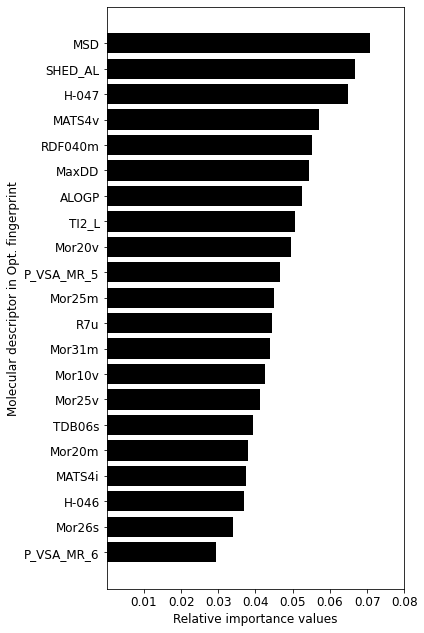

In [5]:
# just plotting the RF_Feature importance ranking here again
# easy to compare against SHAP plots
importances = RF_Regressor.feature_importances_
print(len(importances))

indices = np.argsort(importances)
features = X_train.columns
#indices = indices[0:30]

plt.figure(figsize=(6,8.9))

#plt.title('COE Feature importances')

plt.barh(range(len(indices)), importances[indices], color='k', align='center')

plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=12)
plt.xticks([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08], fontsize=12)
plt.xlabel('Relative importance values', fontsize=12)
plt.ylabel('Molecular descriptor in Opt. fingerprint', fontsize=12)
plt.tight_layout()

plt.savefig('./Results/Final RF feature importances.pdf')
plt.savefig('./Results/Final RF feature importances.svg')
plt.savefig('./Results/Final RF feature importances.png')

plt.show()





In [6]:
explainer = shap.TreeExplainer(RF_Regressor)

        Labels    Values
0       Mor26s  0.042749
1       MATS4i  0.060850
2       Mor20m  0.069123
3   P_VSA_MR_6  0.073054
4       Mor25v  0.075152
5       Mor20v  0.081156
6       TDB06s  0.082592
7       Mor25m  0.091966
8          R7u  0.096069
9        TI2_L  0.098686
10      Mor31m  0.099992
11       H-046  0.105967
12  P_VSA_MR_5  0.107173
13      Mor10v  0.110342
14       MaxDD  0.112811
15      MATS4v  0.115551
16     RDF040m  0.119029
17     SHED_AL  0.132324
18         MSD  0.143189
19       ALOGP  0.143235
20       H-047  0.151625


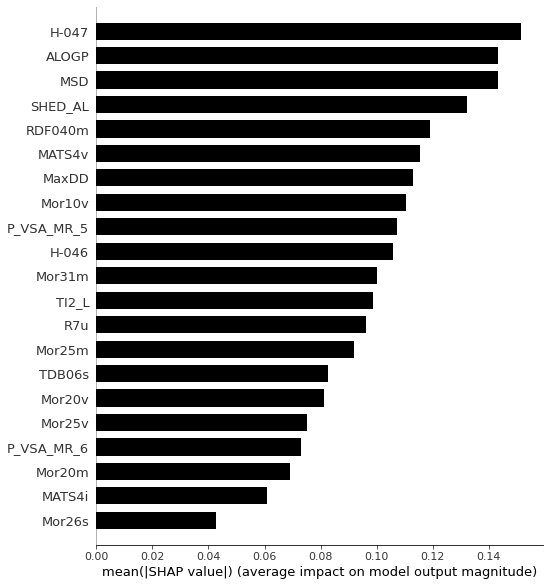

In [7]:
# this first plot is basic shap plot with bars showing average shap value in each feature
# similar to feature importance ranking above

shap_values = explainer.shap_values(X_train)
ax =shap.summary_plot(shap_values, X_train, plot_type="bar", title='Train', max_display=30, show=False, color='k')
plt.savefig('./Results/Final SHAP feature importances - bars.pdf')
plt.savefig('./Results/Final SHAP feature importances - bars.svg')
plt.savefig('./Results/Final SHAP feature importances - bars.png')

ax = plt.gca()
labels = [l.get_text() for l in ax.get_yticklabels()]
values = [rect.get_width() for rect in ax.patches]
df = pd.DataFrame({'Labels': labels, 'Values': values})

print(df)

In [8]:
########################################################################################################

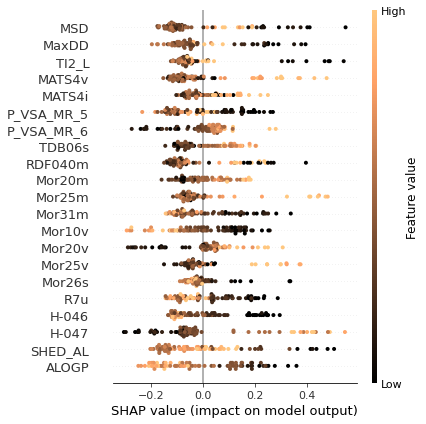

SHAP(ALOGP)<-0.1 molecules:
        no                        name  log2mic
85    87.0          COE2-3C-C4isohexyl      2.0
50    52.0         COE2-3C-C3-1EtPr-HH      2.0
86    88.0         COE2-3C-C4isopentyl      2.0
110  120.0                     COE-Y46      1.0
94    96.0               COE2-3C-C4pip      2.0
127  137.0                       D6IM2      3.0
45    47.0                 COE2-3C-3,3      3.0
15    16.0                 COE-D6N22N2      2.0
91    93.0            COE2-3C-C4MeC6P3      4.0
62    64.0          COE2-3C-C3dipropyl      1.0
3      4.0                   COE-A8IM2      0.0
80    82.0             COE2-3C-C4butyl      2.0
40    41.0             COE2-2isopentyl      2.0
124  134.0                        D46C      0.0
59    61.0           COE2-3C-C3dibutyl      3.0
125  135.0                        A46C      1.0
113  123.0                     COE-Y66      1.0
38    39.0                 COE2-2hexyl      2.0
92    94.0            COE2-3C-C4MeC6P4      6.0
39    40.0  

In [10]:
# second plot is shap plot with scattering of each data point's shap value

# Feature importance: Variables are ranked in descending order.
# Impact: The horizontal single data point location shows whether the effect 
# of that value is associated with a higher or lower prediction.
# Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
# Correlation: if lots of red in X+ axis and lots of blue in X- axis, then feature is positively correlated. vise versa.

#shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, X_test, max_display = 50)

shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display = 50, show=False, cmap='copper', plot_size=(6,6), sort=False)
plt.tight_layout()
plt.savefig('./Results/Final SHAP feature importances - points.pdf')
plt.savefig('./Results/Final SHAP feature importances - points.svg')
plt.savefig('./Results/Final SHAP feature importances - points.png', dpi=300)
plt.show()




# Pick descriptor index and limit from the plot and insert it here.
chosen_descriptor = 'ALOGP'
upper_lim = -0.1
print('SHAP(' + chosen_descriptor + ')<' + str(upper_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
pd.options.display.max_colwidth = 200
print(dataset.loc[y_train[shap_values[:,chosen_index]<upper_lim].index,['no', 'name', 'log2mic']])


In [11]:
########################################################################################################
# Pick descriptor index and limit from the plot and insert it here.
chosen_descriptor = 'Mor20m'
lower_lim = 0.18
print('SHAP(' + chosen_descriptor + ')>' + str(lower_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
print(dataset.loc[y_train[shap_values[:,chosen_index]>lower_lim].index,['no', 'name', 'log2mic', chosen_descriptor]])

upper_lim = -0.15
print('SHAP(' + chosen_descriptor + ')<' + str(upper_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
print(dataset.loc[y_train[shap_values[:,chosen_index]<upper_lim].index,['no', 'name', 'log2mic', chosen_descriptor]])

# Pick descriptor index and limit from the plot and insert it here.
chosen_descriptor = 'Mor10v'
lower_lim = 0
print('SHAP(' + chosen_descriptor + ')>' + str(lower_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
print(dataset.loc[y_train[shap_values[:,chosen_index]>lower_lim].index,['no', 'name', 'log2mic', chosen_descriptor]])

upper_lim = 0
print('SHAP(' + chosen_descriptor + ')<' + str(upper_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
print(dataset.loc[y_train[shap_values[:,chosen_index]<upper_lim].index,['no', 'name', 'log2mic', chosen_descriptor]])

# Pick descriptor index and limit from the plot and insert it here.
chosen_descriptor = 'Mor31m'
lower_lim = 0.0
print('SHAP(' + chosen_descriptor + ')>' + str(lower_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
print(dataset.loc[y_train[shap_values[:,chosen_index]>lower_lim].index,['no', 'name', 'log2mic', chosen_descriptor]])

upper_lim = -0.0
print('SHAP(' + chosen_descriptor + ')<' + str(upper_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
print(dataset.loc[y_train[shap_values[:,chosen_index]<upper_lim].index,['no', 'name', 'log2mic', chosen_descriptor]])

# Pick descriptor index and limit from the plot and insert it here.
chosen_descriptor = 'Mor26m'
lower_lim = 0.1
print('SHAP(' + chosen_descriptor + ')>' + str(lower_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
print(dataset.loc[y_train[shap_values[:,chosen_index]>lower_lim].index,['no', 'name', 'log2mic', chosen_descriptor]])

upper_lim = -0.1
print('SHAP(' + chosen_descriptor + ')<' + str(upper_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
print(dataset.loc[y_train[shap_values[:,chosen_index]<upper_lim].index,['no', 'name', 'log2mic', chosen_descriptor]])

# Pick descriptor index and limit from the plot and insert it here.
chosen_descriptor = 'ALOGP'
lower_lim = 0.0
print('SHAP(' + chosen_descriptor + ')>' + str(lower_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
print(dataset.loc[y_train[shap_values[:,chosen_index]>lower_lim].index,['no', 'name', 'log2mic', chosen_descriptor]])

upper_lim = -0.0
print('SHAP(' + chosen_descriptor + ')<' + str(upper_lim) + ' molecules:')
chosen_index = X_train.columns.get_loc(chosen_descriptor)
#print(shap_values[:,chosen_index]>lower_lim)
print(dataset.loc[y_train[shap_values[:,chosen_index]<upper_lim].index,['no', 'name', 'log2mic', chosen_descriptor]])



SHAP(Mor20m)>0.18 molecules:
      no              name  log2mic    Mor20m
89  91.0  COE2-3C-C4MeC4P4      8.0  1.816205
SHAP(Mor20m)<-0.15 molecules:
        no  name  log2mic    Mor20m
124  134.0  D46C      0.0 -0.051288
SHAP(Mor10v)>0 molecules:
        no                 name  log2mic    Mor10v
19    20.0             COE-D61N      7.0  0.330610
35    36.0               COE2-2      7.0  0.438021
21    22.0             COE-D62N      3.0  0.289701
70    72.0  COE2-3C-C3propylNH2      5.0  0.622719
52    54.0           COE2-3C-C3      6.0 -0.127196
112  122.0             COE-Y62N      4.0  0.327927
58    60.0      COE2-3C-C3DABCO      8.0 -0.311316
26    27.0             COE-D82N      3.0  0.337089
46    48.0           COE2-3C-C2      7.0 -0.026257
27    28.0               COE-T4      5.0  0.259008
114  124.0               COE-Y6      7.0  0.332568
55    57.0      COE2-3C-C3butyl      2.0 -0.015508
99   101.0                 DSSN      8.0  0.259957
16    17.0               COE-D8      

KeyError: 'Mor26m'

In [12]:
# this is a collective force plot that I recommend for this study
# It collectively shows how much each feature can contribute to increasing/decreasing objective values
# its uniqueness is in the "force" nature, almost putting data in a flowing tube, where two powers of +/- correlation 
# are clashing with different features backing them up


# X-axis is how many data points, which you can sample reorder by similarity
# for each X, a force plot (column of shap values from different features, distinguished by red/blue color) is plotted
# stack these up horizontally to get the collective force plot
# Y-axis is predicted output objective value usually, and can be highlighted 
# features that push predictions higher are in red, push to lower are in blue


# to understand more
# https://www.nature.com/articles/s41551-018-0304-0.epdf?author_access_token=vSPt7ryUfdSCv4qcyeEuCdRgN0jAjWel9jnR3ZoTv0PdqacSN9qNY_fC0jWkIQUd0L2zaj3bbIQEdrTqCczGWv2brU5rTJPxyss1N4yTIHpnSv5_nBVJoUbvejyvvjrGTb2odwWKT2Bfvl0ExQKhZw%3D%3D

#shap_values = explainer.shap_values(X_test)
#shap.force_plot(explainer.expected_value, shap_values, X_test)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, shap_values, X_train)
#print(X_train.iloc[67,:])

In [13]:
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values, X_test)

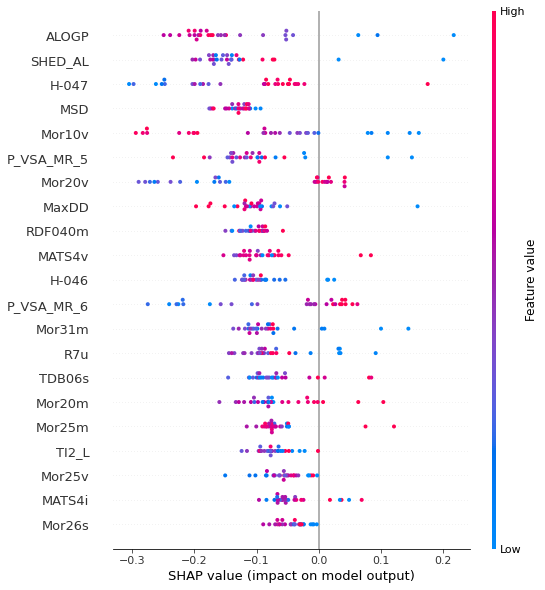

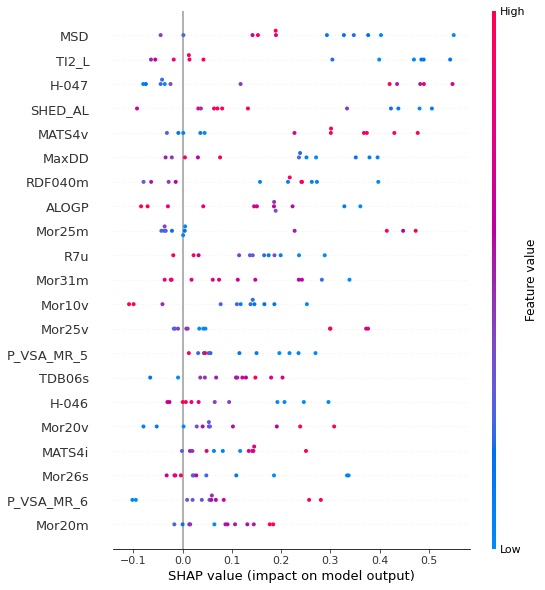

In [14]:
# SHAP analysis for molecules with low and high MIC.
X_train_lowmic = X_train[y_train.values<3]
shap_values = explainer.shap_values(X_train_lowmic)
shap.summary_plot(shap_values, X_train_lowmic, max_display = 50)
shap.force_plot(explainer.expected_value, shap_values, X_train_lowmic)

X_train_highmic = X_train[y_train.values>6]
shap_values = explainer.shap_values(X_train_highmic)
shap.summary_plot(shap_values, X_train_highmic, max_display = 50)
shap.force_plot(explainer.expected_value, shap_values, X_train_highmic)

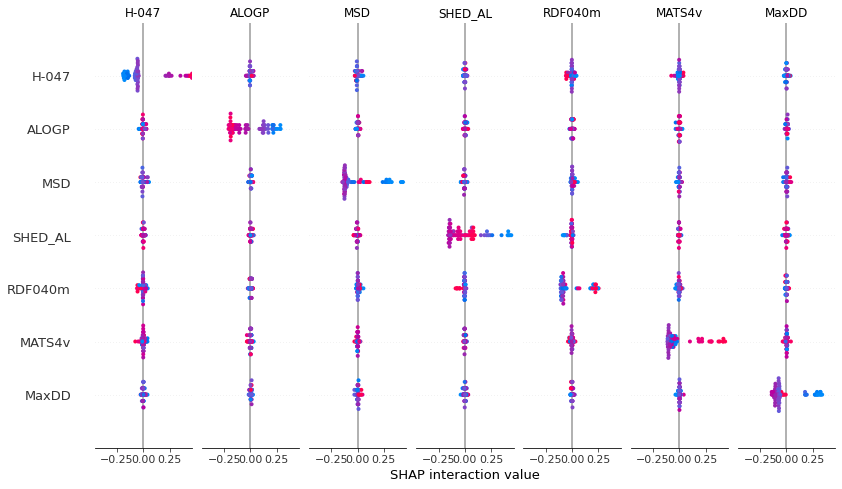

In [15]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train)

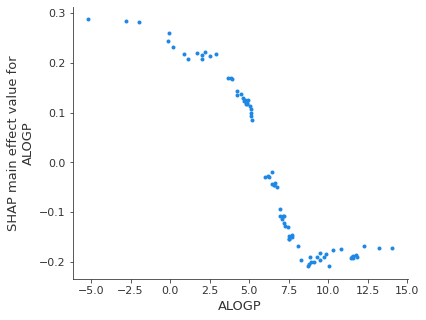

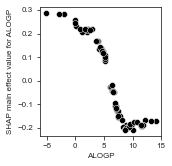

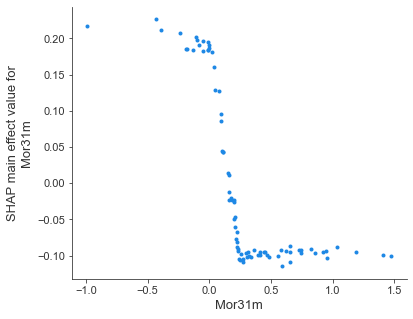

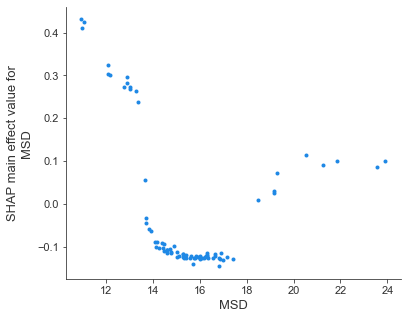

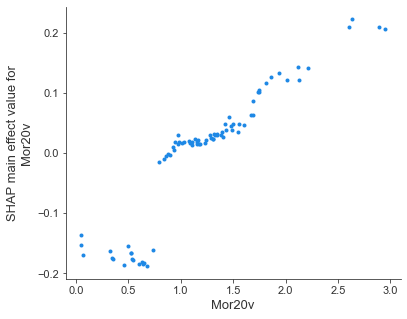

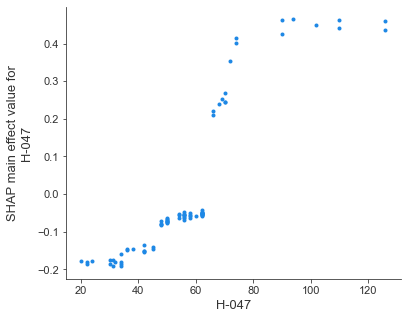

In [17]:
mystyle = FigureDefaults('nature_comp_mat_sc')
mystyle.size_fraction_x = 0.4

fig,ax = plt.subplots()
shap.dependence_plot(
    ("ALOGP", "ALOGP"),
    shap_interaction_values, X_train,
    display_features=X_train,
    cmap='copper', show=False, ax=ax
)
plt.show()

xdata=np.array(ax.collections[0].get_offsets())
ydata=np.ravel(xdata[:,1])
xdata=np.ravel(xdata[:,0])
xlabel=ax.collections[0].get_label()
#fig = plt.gcf()
#fig.set_size_inches(plt.rcParams['figure.figsize'][0],plt.rcParams['figure.figsize'][1])
#ax = plt.gca()
#print(ax)
#line = ax.lines
#print(line)
#color = np.array(sns.color_palette())[0,:]
#    sns.set_style('ticks')
#    sns.relplot(x=x_variable, y="RMSE", kind="line", ci="sd", data=ranking_scores,
#        height=plt.rcParams['figure.figsize'][0],
#        aspect=plt.rcParams['figure.figsize'][1]/plt.rcParams['figure.figsize'][0],
#        color=color, style='ticks')


sn.set_style('ticks')
sn.set_palette('copper')
ax=sn.scatterplot(x=xdata,
            y=ydata,
            #height=plt.rcParams['figure.figsize'][0],
            #aspect=plt.rcParams['figure.figsize'][1]/plt.rcParams['figure.figsize'][0])#,
            color='k')#np.array(sn.color_palette())[4,:])
            #palette='copper')

#{'font.size': 10, 'figure.figsize': (6.0, 4.0), 'figure.facecolor': 'white', 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125, 'figure.edgecolor': 'white'}
ax.set_xlabel('ALOGP')
ax.set_ylabel('SHAP main effect value for ALOGP')
#handles, labels = ax.get_legend_handles_labels()
#plt.legend(handles[:1], labels[:1], loc='upper right', frameon=True, markerscale=0.5, borderpad=0.2,
#           labelspacing=0.2, borderaxespad=0.3, handlelength=1)

plt.tight_layout()
plt.savefig('./Results/Train Opt fingerprint seed 3 - AlogP.pdf')
plt.savefig('./Results/Train Opt fingerprint seed 3 - AlogP.svg')
plt.savefig('./Results/Train Opt fingerprint seed 3 - AlogP.png', dpi=300)
plt.show()

shap.dependence_plot(
    ("Mor31m", "Mor31m"),
    shap_interaction_values, X_train,
    display_features=X_train
)

shap.dependence_plot(
    ("MSD", "MSD"),
    shap_interaction_values, X_train,
    display_features=X_train
)

shap.dependence_plot(
    ("Mor20v", "Mor20v"),
    shap_interaction_values, X_train,
    display_features=X_train
)

shap.dependence_plot(
    ("H-047", "H-047"),
    shap_interaction_values, X_train,
    display_features=X_train
)

In [ ]:
# High - low - high combination leads to low MIC according to the model? Morse values require more investigation.
print(np.max(X_train.loc[:, ['Mor31m', 'Mor20m', 'Mor20v']]))#'Mor11m']]))
print(np.min(X_train.loc[:, ['Mor31m', 'Mor20m', 'Mor20v']]))
X_train.loc[:, ['Mor31m', 'Mor20m', 'Mor20v']]